<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Qiskit_based_electronic_bandstructure_latest_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook shows a few examples to use [JARVIS-Tools](https://github.com/usnistgov/jarvis), [AtomQC](https://github.com/usnistgov/atomqc) and [Qiskit](https://qiskit.org/) packages to generate electronic bandstructure for [Aluminum](https://www.ctcms.nist.gov/~knc6/static/JARVIS-DFT/JVASP-816.xml). 
#For details see: https://iopscience.iop.org/article/10.1088/1361-648X/ac1154/meta

Note: We are pinning versions of some of the packages as qiskit might have renamed/modified its modules

In [1]:
!pip  install jarvis-tools qiskit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.3/973.3 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.1/515.1 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 M

In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
import numpy as np
import itertools, functools
from qiskit.opflow import I, X, Y, Z
from jarvis.db.figshare import get_wann_electron, get_wann_phonon, get_hk_tb
from jarvis.core.circuits import QuantumCircuitLibrary


def decompose_Hamiltonian(H):
    #Inspired from
    # https://github.com/PennyLaneAI/pennylane/blob/master/pennylane/utils.py#L45
    # https://qiskit.org/documentation/tutorials/algorithms/04_vqe_advanced.html
    x, y = H.shape
    N = int(np.log2(len(H)))
    if len(H) - 2 ** N != 0 or x != y:
        raise ValueError(
            "Hamiltonian should be in the form (2^n x 2^n), for any n>=1")
    pauilis = [I, X, Y, Z]
    decomposedH = 0
    for term in itertools.product(pauilis, repeat=N):
        matrices = [i.to_matrix() for i in term]
        # coefficient of the pauli string = (1/2^N) * (Tr[pauliOp x H])
        coeff = np.trace(functools.reduce(np.kron, matrices) @ H) / (2**N)
        coeff = np.real_if_close(coeff).item()
        if coeff == 0:
            continue
        obs = 1
        for i in term:
            obs = obs ^ i
        decomposedH += coeff * obs
    return decomposedH



wtbh, Ef, atoms = get_wann_electron("JVASP-816")
kpt = [0.5, 0., 0.5] # X-point
hk = get_hk_tb(w=wtbh, k=kpt)
wtbh_op=decompose_Hamiltonian(hk)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
n_qubits = int(np.log2(len(hk)))
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
ansatz = QuantumCircuitLibrary(n_qubits=n_qubits, reps=1).circuit6()
slsqp = SLSQP(maxiter=1000)
vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=wtbh_op)
np_eig = min(np.linalg.eig(hk)[0])
print ('numpy min. eig', np_eig )

eigenvalue = result.eigenvalue
#print(result)
print('VQE eig.', eigenvalue)

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1


100%|██████████| 6.00M/6.00M [00:02<00:00, 2.85MiB/s]


Loading the zipfile...
Loading completed.
H size 15 13 15 8 8
numpy min. eig (4.885195094715013+4.342664158701647e-16j)
VQE eig. (4.885211308472339+0j)


In [3]:
from jarvis.db.figshare import get_wann_electron, get_wann_phonon, get_hk_tb
from jarvis.io.qiskit.inputs import HermitianSolver
from jarvis.core.circuits import QuantumCircuitLibrary
from qiskit import Aer

backend = Aer.get_backend("statevector_simulator")
# Aluminum JARVIS-ID: JVASP-816
wtbh, Ef, atoms = get_wann_electron("JVASP-816")
kpt = [0.5, 0., 0.5] # X-point
hk = get_hk_tb(w=wtbh, k=kpt)
HS = HermitianSolver(hk)
n_qubits = HS.n_qubits()
circ = QuantumCircuitLibrary(n_qubits=n_qubits, reps=1).circuit6()
en, vqe_result, vqe = HS.run_vqe(var_form=circ, backend=backend)
vals,vecs = HS.run_numpy()
# Ef: Fermi-level
print('Classical, VQE (eV):', vals[0]-Ef, en-Ef)
print('Show model\n', circ)

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
H size 15 13 15 8 8
Classical, VQE (eV): -3.0437167852849907 (-3.043700571527661+0j)
Show model
      »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                             ├
«     │                                                                              │
«q_1: ┤1 EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) ├
«     │                                                                              │
«q_2: ┤2                                                                             ├
«     └──────────────────────────────────────────────────────────────────────────────┘


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex

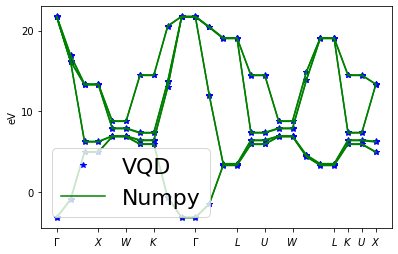

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from jarvis.io.qiskit.inputs import get_bandstruct
out=get_bandstruct(w=wtbh,atoms=atoms, line_density=1, savefig=False)
# Scroll down to see th plot

In [8]:
len(out)

6

In [10]:
out.keys()

dict_keys(['eigvals_q', 'eigvals_np', 'kpts', 'new_kp', 'new_labels', 'ef'])

In [17]:
import numpy as np

eigvals_q = (np.array(out['eigvals_q']).real).flatten()
eigvals_np = (np.array(out['eigvals_np']).real).flatten()

In [20]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(eigvals_np,eigvals_q))

0.0029637342224714384


In [25]:
out['new_kp']

[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]

In [26]:
out['new_labels']

['$\\Gamma$',
 '$X$',
 '$W$',
 '$K$',
 '$\\Gamma$',
 '$L$',
 '$U$',
 '$W$',
 '$L$',
 '$K$',
 '$U$',
 '$X$']

In [27]:
out['ef']

0

In [24]:
out['kpts']

[[0.0, 0.0, 0.0],
 [0.25, 1.7967564939297314e-17, 0.25],
 [0.5, 3.593512987859463e-17, 0.5],
 [0.5, 3.593512987859463e-17, 0.5],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.24999999999999997, 0.75],
 [0.375, 0.37499999999999994, 0.75],
 [0.375, 0.37499999999999994, 0.75],
 [0.1875, 0.18749999999999997, 0.375],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.25, 0.25, 0.25],
 [0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.375, 0.625],
 [0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5],
 [0.375, 0.37499999999999994, 0.75],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.5, 3.593512987859463e-17, 0.5]]

In [21]:
eigvals_q


array([-3.24066269, -3.16443735, 21.63721949, 21.64572101, 21.6848682 ,
       21.69508497, 21.73149934, 21.75362106, -0.99044918, -0.91496008,
       16.11340511, 16.1285841 , 16.16823014, 16.18714046, 16.87307868,
       16.95509118,  4.88520351,  4.95714776,  6.16094672,  6.24118643,
       13.2610694 , 13.27919225, 13.32299075, 13.35497151,  4.88520351,
        4.95714776,  6.16094672,  6.24118643, 13.2610694 , 13.27919225,
       13.32299075, 13.35497151,  6.81048262,  6.8546334 ,  6.88072178,
        6.92519056,  7.80902871,  7.89950469,  8.72012799,  8.78517464,
        6.81048262,  6.8546334 ,  6.88072178,  6.92519056,  7.80902871,
        7.89950469,  8.72012799,  8.78517464,  5.86633622,  5.9368361 ,
        6.33828584,  6.41701939,  7.27135868,  7.34574883, 14.4217756 ,
       14.4953806 ,  5.86633622,  5.9368361 ,  6.33828584,  6.41701939,
        7.27135868,  7.34574883, 14.4217756 , 14.4953806 , -0.75363526,
       -0.67758079, 12.94532159, 13.00174039, 13.65328535, 13.68

In [23]:
eigvals_np


array([-3.24066445, -3.16463202, 21.64459304, 21.66631242, 21.68275108,
       21.7124318 , 21.73906807, 21.75494905, -0.99045319, -0.91496282,
       16.11225158, 16.12899456, 16.16829145, 16.18771485, 16.87352861,
       16.95579697,  4.88519509,  4.95713807,  6.16090983,  6.24112862,
       13.26135091, 13.27946273, 13.33681169, 13.35498806,  4.88519509,
        4.95713807,  6.16090983,  6.24112862, 13.26135091, 13.27946273,
       13.33681169, 13.35498806,  6.81020172,  6.85347494,  6.88180512,
        6.92537732,  7.8089345 ,  7.89957294,  8.72041664,  8.78519182,
        6.81020172,  6.85347494,  6.88180512,  6.92537732,  7.8089345 ,
        7.89957294,  8.72041664,  8.78519182,  5.86627843,  5.93674378,
        6.33836942,  6.41702087,  7.27134612,  7.3456925 , 14.42184882,
       14.49540139,  5.86627843,  5.93674378,  6.33836942,  6.41702087,
        7.27134612,  7.3456925 , 14.42184882, 14.49540139, -0.75363696,
       -0.67767805, 12.9452385 , 13.00179078, 13.65324355, 13.68

In [28]:
!pip freeze

absl-py==1.4.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==6.0.0
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==4.0.0
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==2.2.1
cmake==3.22.6
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cryptography==39.0.1
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.3
cycler==0.11.0
cymem==2.0.7
Cython==0.29.33
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.5
dbus-python==1.2.16
debugpy==1.0.